# Project: Advanced Lane Finding
---
### The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---

## Import Packages

In [1]:
# importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
from time import sleep
%matplotlib inline

# global debug flag
DEBUG = False

## Camera Calibration

In [2]:
# prepare object points
nx = 9 # number of inside corners in x
ny = 6 # number of inside corners in y

objpoints = []
imgpoints = []

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ..., (nx-1,ny-1,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates

# Make a list of calibration images
fnames = glob.glob('camera_cal/calibration*.jpg')

# Iterate trough all calibration images
for fname in fnames:
    img = mpimg.imread(fname)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, add object points and image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        if DEBUG:
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            plt.imshow(img)
            plt.show()
    else:
        print("No corners found in the following image:", fname)


No corners found in the following image: camera_cal\calibration1.jpg
No corners found in the following image: camera_cal\calibration4.jpg
No corners found in the following image: camera_cal\calibration5.jpg


In [3]:
# Camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[:2], None, None)

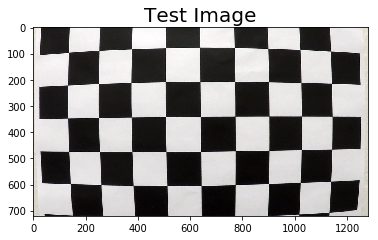

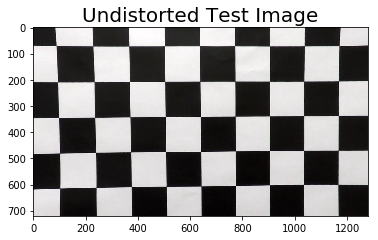

In [4]:
# Test camera calibration on one of the calibration images
img = mpimg.imread(fnames[0])

plt.title('Test Image', fontsize=20)
plt.imshow(img)
plt.show()

undist = cv2.undistort(img, mtx, dist, None, mtx)

plt.title('Undistorted Test Image', fontsize=20)
plt.imshow(undist)
plt.show()

## Helper Functions and Classes

In [5]:
# Definition of some helper functions and classes that will be used later

def undistort(img, mtx, dist):
    '''
    This function receives a distorted image and returns it undistorted.
    '''
    return cv2.undistort(img, mtx, dist, None, mtx)

def lane_filter(img, h_thresh=(15, 40), s_thresh=(175, 255), sx_thresh=(20, 100), white_thresh = 198):
    '''
    This function receives a road image with lane lines and returns a binary image
    where the lane lines are marked with 1s and most of the rest is marked with 0s.
    '''
    img = np.copy(img)
    
    r_channel = img[:,:,0]
    g_channel = img[:,:,1]
    b_channel = img[:,:,2]
    
    w_binary = np.zeros_like(r_channel)
    w_binary[(r_channel >= white_thresh) & (g_channel >= white_thresh) & (b_channel >= white_thresh)] = 1
    
    # Convert to HLS color space and separate the channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    #hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Threshold color channels
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    hs_binary = np.zeros_like(h_channel)
    hs_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1]) & (s_channel >= 90)] = 1
    
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=3) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1]) & \
              (s_channel >= 12) & (l_channel >= 12)] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    #color_binary = np.dstack((hs_binary, s_binary, sxbinary))
    
    combined = np.zeros_like(s_binary)
    combined[(hs_binary == 1) | (s_binary == 1) | (w_binary == 1) | (sx_binary == 1)] = 1
    #combined[(sx_binary == 1)] = 1
    return combined

def fit_lanes(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    
#     midpoint = np.int(histogram.shape[0]/2)
#     leftx_base = np.argmax(histogram[:midpoint])
#     rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # To be precise: the histogram is cut into seven parts
    # and we search only part 2 and 3 for the left starting point
    # and we search only part 5 and 6 for the right starting point:
    # 7 parts of the histogram:  |x|L|L|x|R|R|x|  (x: not searched, L/R: search for left/right starting point)
    one7th = np.int(histogram.shape[0]/7.)
    leftx_base = np.argmax(histogram[one7th : (3*one7th)]) + one7th
    rightx_base = np.argmax(histogram[(4*one7th) : (6*one7th)]) + 4*one7th
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    if leftx.any():
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        left_fit = []
    if rightx.any():
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = [] 

    return left_fit, right_fit

def region_of_interest(img, vertices, inside=True):
    """
    Applies an image mask. For binary images only!
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black (for inside=True).
    Or vice versa if parameter "inside" is set to False.
    """
    # depending on the value of 'inside', define a all-zeros or all-ones mask to start with
    if inside:
        mask = np.zeros_like(img)
        mask_color = 1
    else:
        mask = np.ones_like(img)
        mask_color = 0
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Advanced Lane Detection Pipeline

In [6]:
def pipeline(image):
    img = image.copy()
    img_size_y, img_size_x, dummy = img.shape
    
    ### Apply a distortion correction to raw images. ################################################
    undist_img = undistort(img, mtx, dist)
    
    ### Use color transforms, gradients, etc., to create a thresholded binary image. ################
    #binary_img = lane_filter(img)
    filtered_img = lane_filter(undist_img)
    
    # Define a four sided polygon to mask the image
    imshape = filtered_img.shape
    poly_height = 0.40  # height of the polygon in proportion of the image height
    poly_bottom_width = 0.85  # in proportion of image width
    poly_top_width = 0.10  # in proportion of image width
    poly_x_offset = 0.02  # offset of the polygon in x direction in proportion of the image width
    vertices = np.array([[\
        (((1+poly_top_width)/2 + poly_x_offset) * imshape[1], (1-poly_height)*imshape[0]),\
        (((1-poly_top_width)/2 + poly_x_offset) * imshape[1], (1-poly_height)*imshape[0]),\
        (((1-poly_bottom_width)/2 + poly_x_offset) * imshape[1], imshape[0]),\
        (((1+poly_bottom_width)/2 + poly_x_offset) * imshape[1], imshape[0])]], dtype=np.int32)
    masked_filtered_img = region_of_interest(filtered_img, vertices)
    
    # Define a three sided polygon (triangle) to mask the image
    poly_height = 0.3
    poly_bottom_width = 0.4
    poly_x_offset = 0.02  # offset of the polygon in x direction in proportion of the image width
    vertices = np.array([[\
        ((0.5 + poly_x_offset) * img_size_x, (1-poly_height)*img_size_y),\
        (((1-poly_bottom_width)/2 + poly_x_offset) * img_size_x, img_size_y),\
        (((1+poly_bottom_width)/2 + poly_x_offset) * img_size_x, img_size_y)]], dtype=np.int32)
    masked_filtered_img = region_of_interest(masked_filtered_img, vertices, inside=False) # the outside area of the triangle will be left as is
    
    line_image = np.copy(image)*0
    line_image[masked_filtered_img == 1] = [255,0,0]
    
    ### Apply a perspective transform to rectify binary image ("birds-eye view"). ###################
    dst_x_offset = 300
    src = np.float32([[img_size_x/2 - 56, 456],[img_size_x/2 + 56, 456], \
                     [img_size_x/2 + 420, 694],[img_size_x/2 - 420, 694]])
#     src = np.float32([[img_size_x/2 - 56, 456],[img_size_x/2 + 56, 456], \
#                      [img_size_x/2 + 447, 720],[img_size_x/2 - 447, 720]])
    # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32([[img_size_x/2 - dst_x_offset, 0],[img_size_x/2 + dst_x_offset, 0], \
                       [img_size_x/2 + dst_x_offset, 719],[img_size_x/2 - dst_x_offset, 719]])
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    binary_warped = cv2.warpPerspective(masked_filtered_img, M, (img_size_x, img_size_y), flags=cv2.INTER_LINEAR)
    
    
    ### Detect lane pixels and fit to find the lane boundary. #######################################
    left_fit, right_fit = fit_lanes(binary_warped)
    
    if left_fit == [] or right_fit == []:
        # TODO: use last valid lane fit
        return masked_filtered_img
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    lane_points = np.column_stack((ploty, left_fitx, right_fitx))
        
    wraped_lane_img = np.copy(image)*0
    wraped_lane_img[binary_warped == 1] = [255,255,255]
    
    for lane_point in lane_points:
        if lane_point[1] < img_size_x and lane_point[1] >= 0:
            wraped_lane_img[int(lane_point[0]), int(lane_point[1])] = [255,0,0]
        if lane_point[2] < img_size_x and lane_point[2] >= 0:
            wraped_lane_img[int(lane_point[0]), int(lane_point[2])] = [255,255,0]
    
    
    ### Determine the curvature of the lane and vehicle position with respect to center. ###########
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
#     left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
#     right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
#     print(left_curverad, right_curverad)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    
    
    ### Warp the detected lane boundaries back onto the original image. #############################
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    #cv2.fillPoly(color_warp, np.array([[0,0],[200,0],[200,200],[0,200]], np.int32), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    
    
    #### Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'left_curverad: ' + str(left_curverad) + 'm, right_curverad: ' + str(right_curverad) + 'm'
    cv2.putText(result,text,(10,710), font, 1,(255,255,255),2,cv2.LINE_AA)
    
    return result

## Apply The Pipeline To Test Images

C:\Program Files\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:48: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


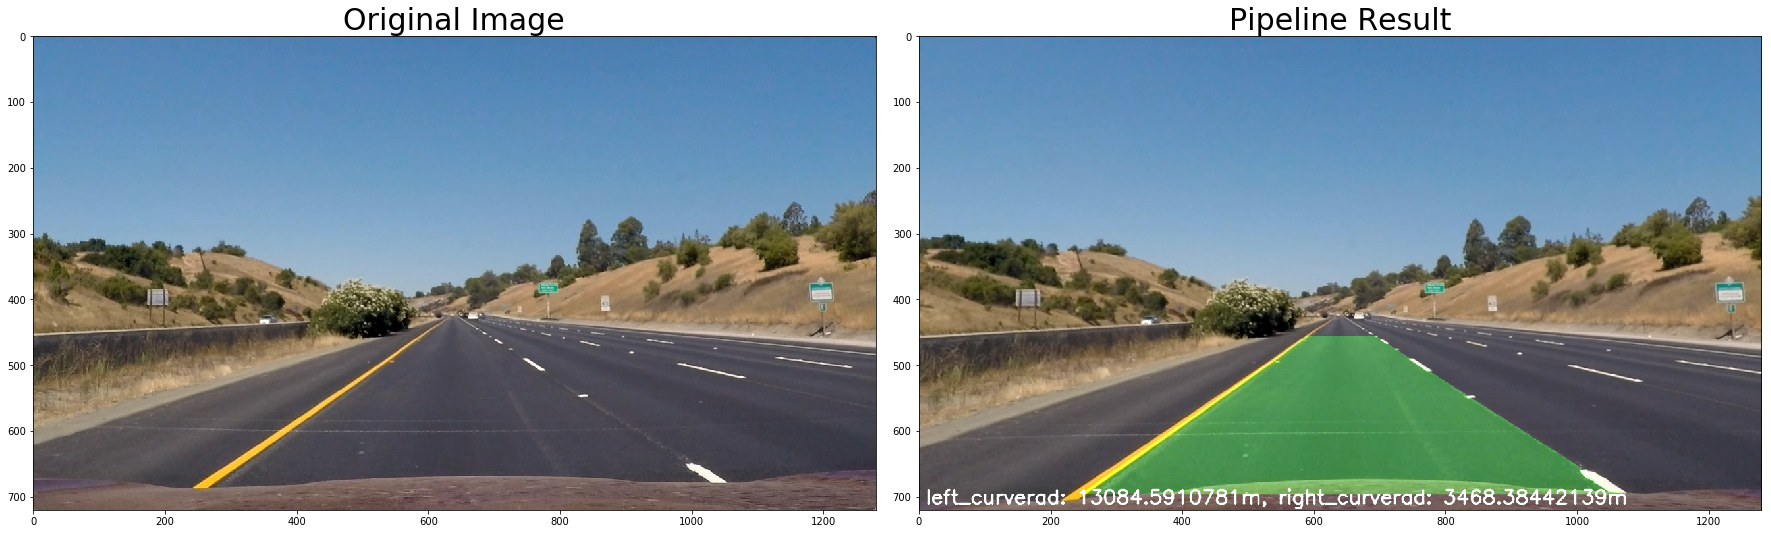

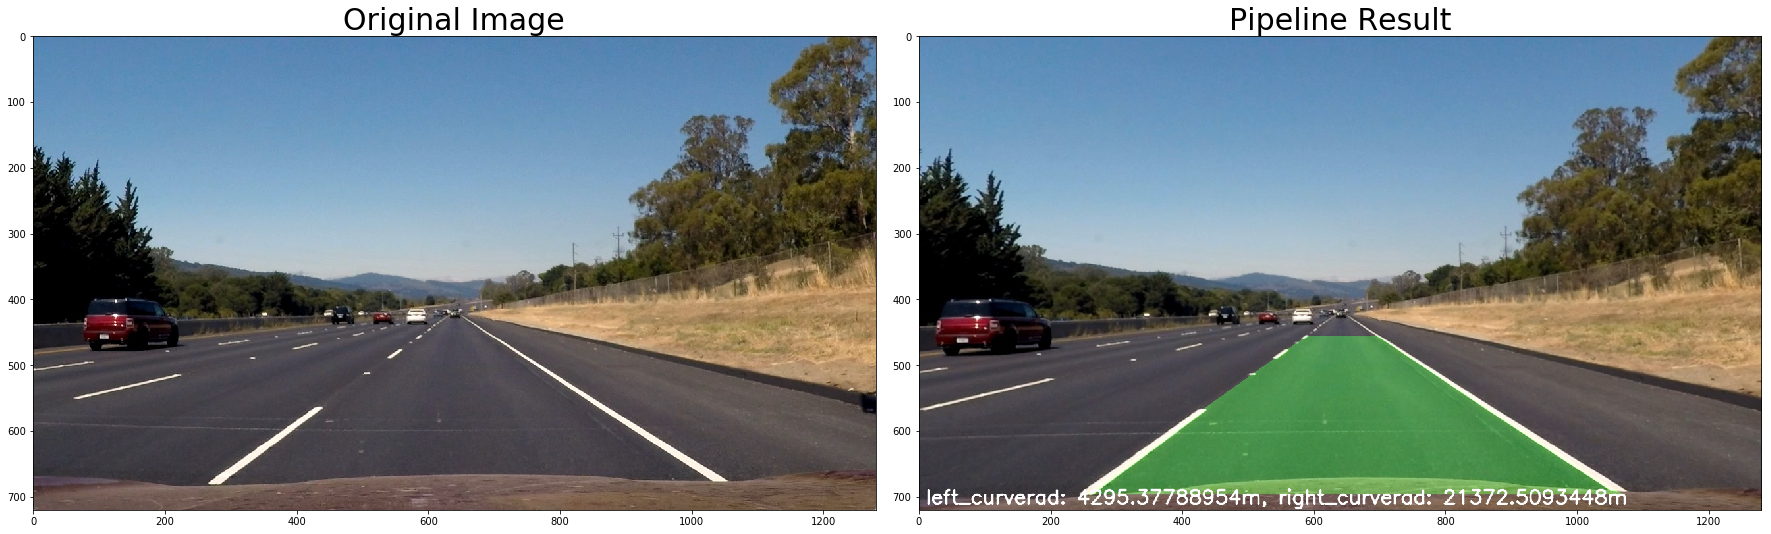

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


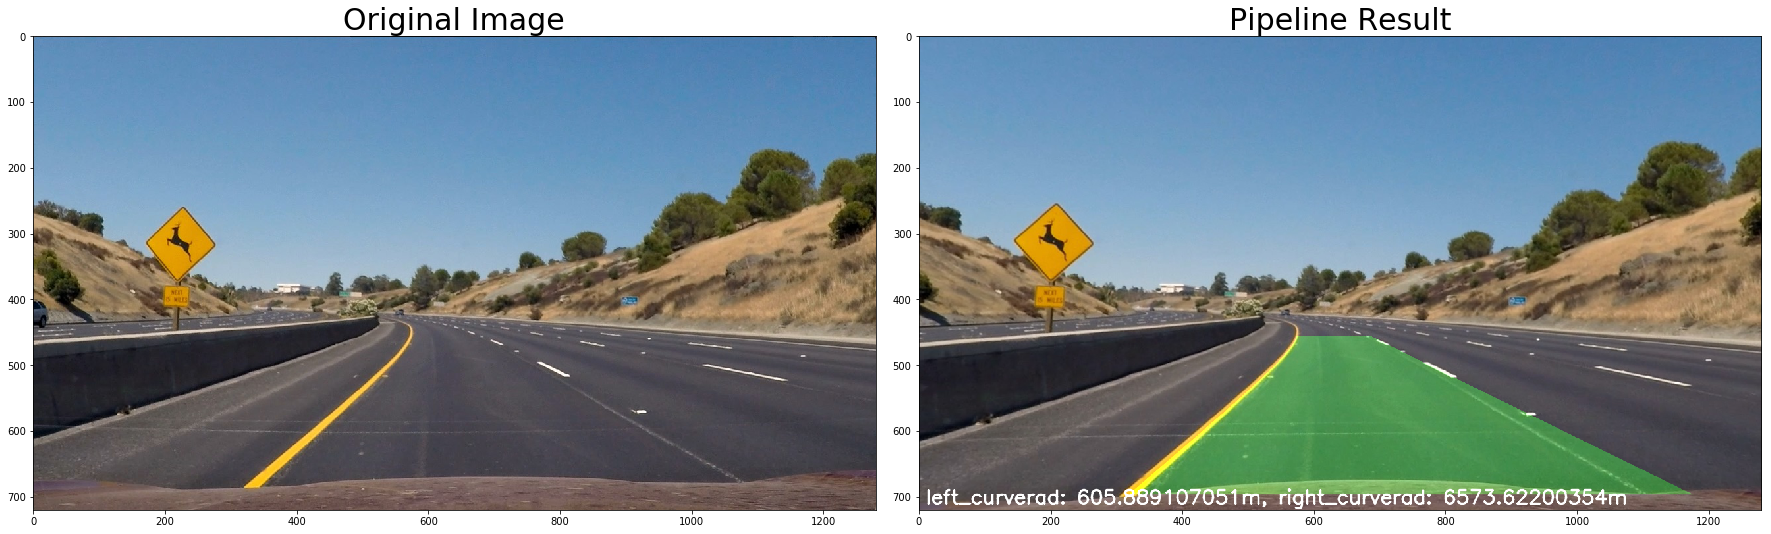

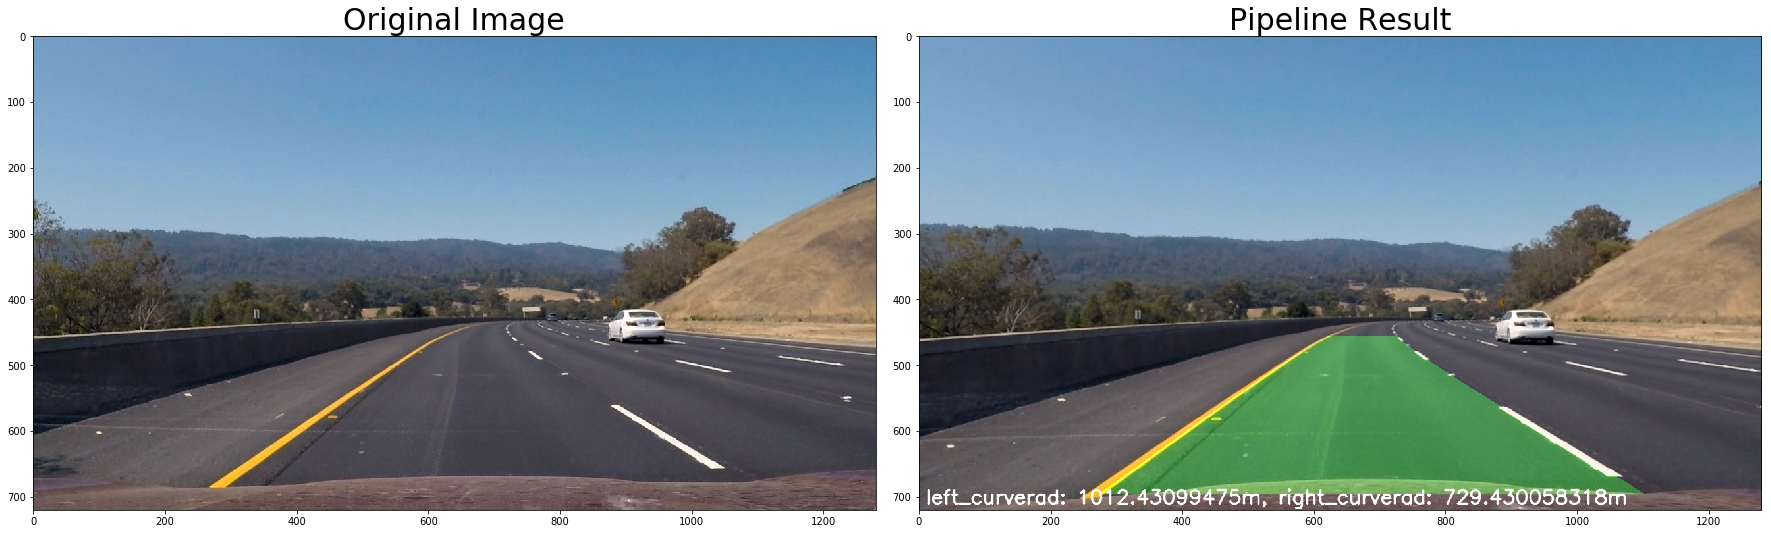

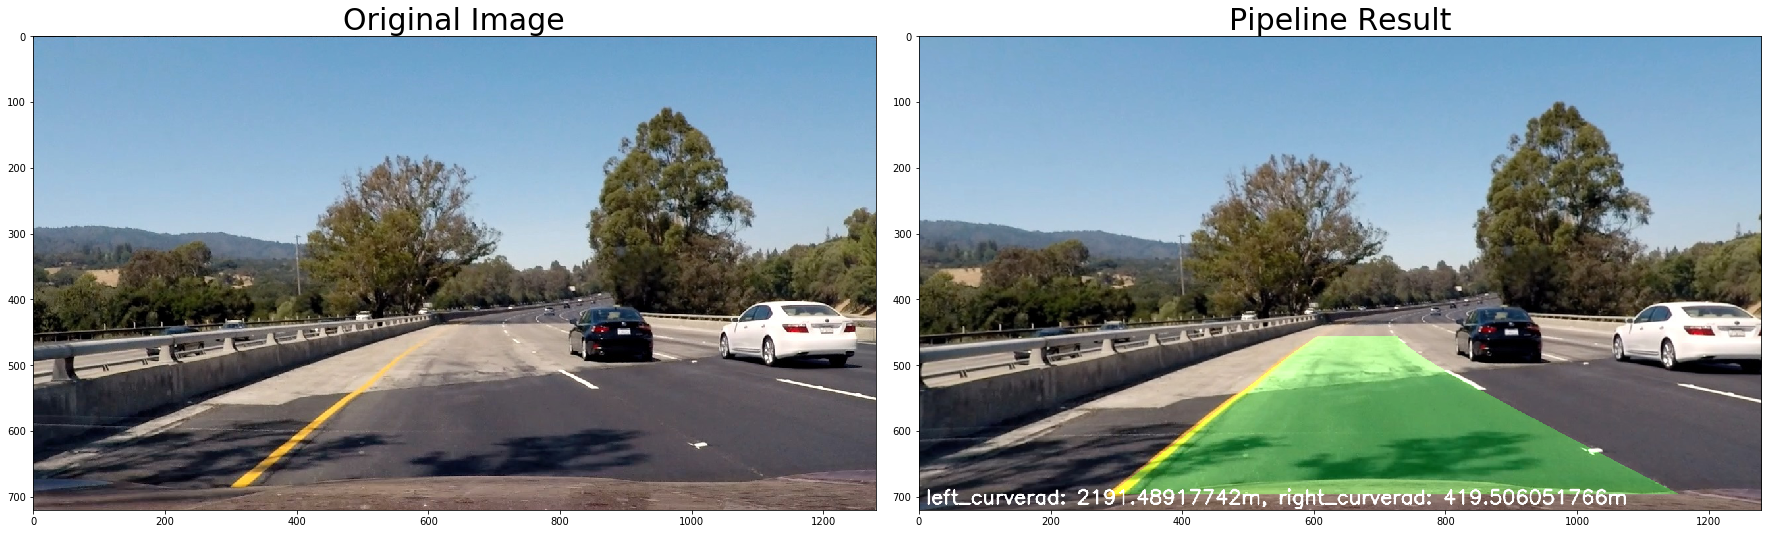

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


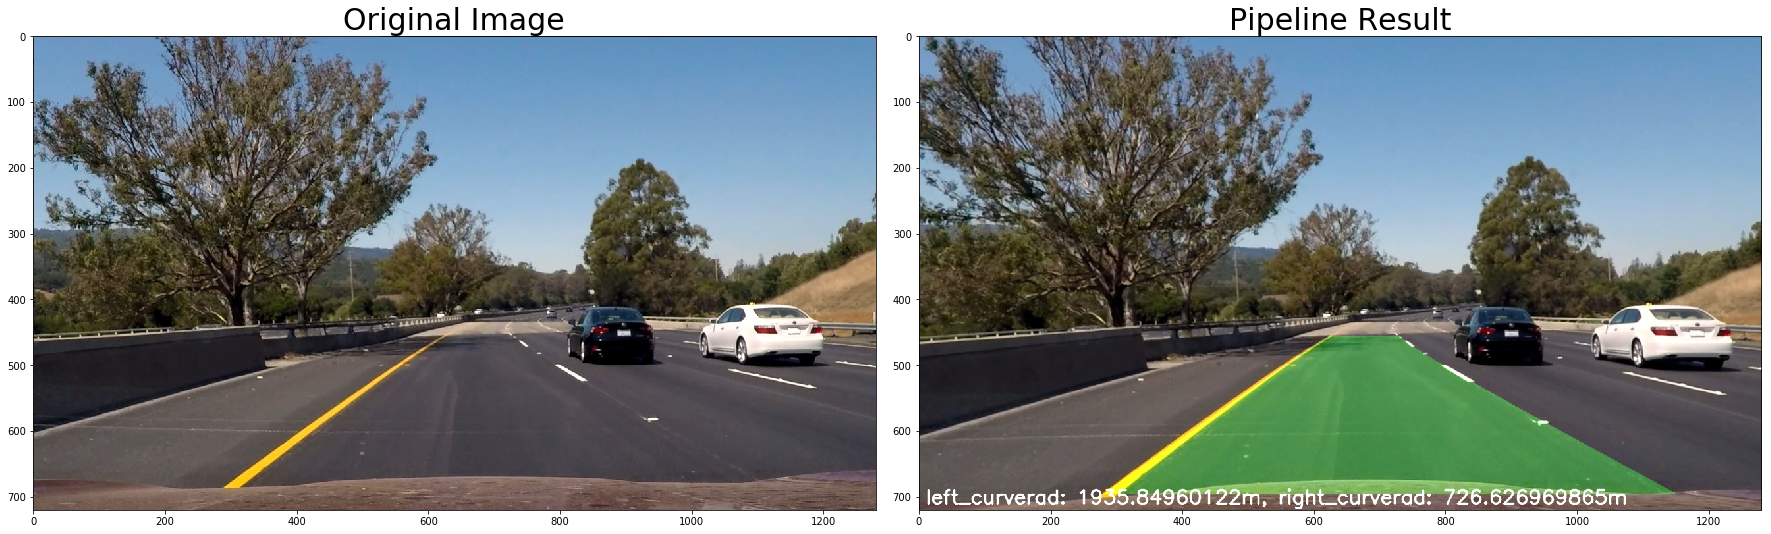

In [7]:
# Make a list of test images
fnames = glob.glob('test_images/*.jpg')

# Iterate trough all test images and apply the pipleline defined above
for filename in fnames:
    img = mpimg.imread(filename)
    result_img = pipeline(img)
    
    # Plot the resulting image next to the original image
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(result_img)
    ax2.set_title('Pipeline Result', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    plt.show()
    
    # Save image
    mpimg.imsave("output_images/" + filename.split('\\')[-1], result_img)
    
    sleep(0.01)

## Apply The Pipeline To Videos

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### project_video.mp4

In [9]:
output_file1 = 'output_videos/project_video_out.mp4'

clip1 = VideoFileClip("project_video.mp4").subclip(30,49.5) #use a subclip for debugging .subclip(start_second,end_second)
#clip1 = VideoFileClip("project_video.mp4")
clip1 = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time clip1.write_videofile(output_file1, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_out.mp4
[MoviePy] Writing video output_videos/project_video_out.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 488/488 [02:02<00:00,  4.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_out.mp4 

Wall time: 2min 3s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file1))

### challenge_video.mp4

In [11]:
output_file2 = 'output_videos/challenge_video_out.mp4'

clip2 = VideoFileClip("challenge_video.mp4").subclip(1,5.5) #use a subclip for debugging .subclip(start_second,end_second)
#clip2 = VideoFileClip("challenge_video.mp4")
clip2 = clip2.fl_image(pipeline) #NOTE: this function expects color images!!
%time clip2.write_videofile(output_file2, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video_out.mp4
[MoviePy] Writing video output_videos/challenge_video_out.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:29<00:00,  4.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video_out.mp4 

Wall time: 31.1 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file2))

### harder_challenge_video.mp4

In [13]:
output_file3 = 'output_videos/harder_challenge_video_out.mp4'

clip3 = VideoFileClip("harder_challenge_video.mp4").subclip(0,5) #use a subclip for debugging .subclip(start_second,end_second)
#clip3 = VideoFileClip("harder_challenge_video.mp4")
clip3 = clip3.fl_image(pipeline) #NOTE: this function expects color images!!
%time clip3.write_videofile(output_file3, audio=False)

[MoviePy] >>>> Building video output_videos/harder_challenge_video_out.mp4
[MoviePy] Writing video output_videos/harder_challenge_video_out.mp4


 99%|███████████████████████████████████████████████████████████████████████████████▎| 125/126 [00:30<00:00,  4.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video_out.mp4 

Wall time: 32.4 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file3))